## Data processing for Experiment 2

In [1]:
import glob
import pickle

kuka_raw = []

for path in glob.glob('./data/magnetic/kuka_dir-rnd_1500k_n10_v2_f10/*.pkl'):
    with open(path, 'rb') as f:
        kuka_raw.append(pickle.load(f))

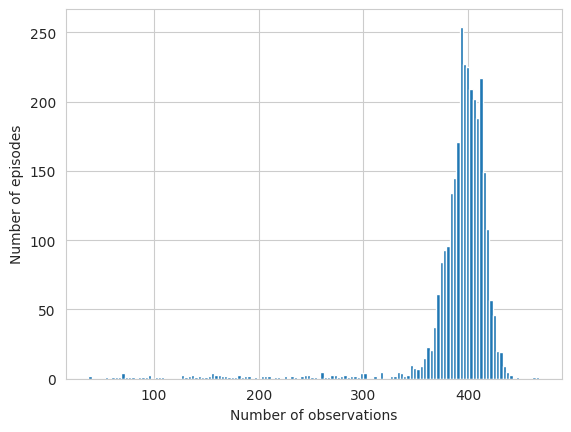

In [2]:
import matplotlib.pyplot as plt

it_counts = [
    len(ep)
    for part in kuka_raw
    for ep in part
]

plt.hist(it_counts, bins='auto')
plt.xlabel('Number of observations')
plt.ylabel('Number of episodes')
plt.show()

In [7]:
import numpy as np
from tqdm import tqdm

n_joints = 7

fwd_data = []
inv_data = []

eff_changes = []
obj_changes = []

raw_data = kuka_raw

for idx, data in enumerate(raw_data):
    for ep in tqdm(data, desc=f'Dataset {idx + 1}/{len(raw_data)}'):
        (
            obj_xyz_0, obj_rot_0, color,
            joints_0, eff_xyz_0, eff_rot_0, _, 
            magnet_0
        ) = np.split(ep[0], [3, 7, 10, 17, 20, 24, 28])

        assert len(obj_xyz_0) == 3
        assert len(obj_rot_0) == 4
        assert len(color) == 3
        assert len(joints_0) == n_joints
        assert len(eff_xyz_0) == 3
        assert len(eff_rot_0) == 4
        assert len(magnet_0) == 1

        for s in ep[1:]:
            (
                obj_xyz_1, obj_rot_1, _,
                joints_1, eff_xyz_1, eff_rot_1, _,
                magnet_1
            ) = np.split(s, [3, 7, 10, 17, 20, 24, 28])

            a = np.concatenate([joints_1 - joints_0, magnet_1 - magnet_0])
            eff_changes.append(eff_xyz_1 - eff_xyz_0)
            obj_changes.append(obj_xyz_1 - obj_xyz_0)

            s0 = np.concatenate([
                obj_xyz_0, obj_rot_0, color,
                joints_0, eff_xyz_0, eff_rot_0,
                magnet_0
            ])

            s1 = np.concatenate([
                obj_xyz_1, obj_rot_1, color,
                joints_1, eff_xyz_1, eff_rot_1,
                magnet_1
            ])

            fwd_data.append((np.concatenate((s0, a)), s1))
            inv_data.append((np.concatenate((s0, s1)), a))

            obj_xyz_0, obj_rot_0 = obj_xyz_1, obj_rot_1
            joints_0 = joints_1
            eff_xyz_0, eff_rot_0 = eff_xyz_1, eff_rot_1
            magnet_0 = magnet_1

Dataset 3/3: 100%|██████████| 1000/1000 [00:30<00:00, 33.15it/s]


In [8]:
X_fwd, y_fwd = map(np.asarray, zip(*fwd_data))
X_inv, y_inv = map(np.asarray, zip(*inv_data))

eff_changes = np.asarray(eff_changes)
obj_changes = np.asarray(obj_changes)

In [9]:
col_dict = {
    'joint_0': X_fwd[:, 10],
    'joint_1': X_fwd[:, 11],
    'joint_2': X_fwd[:, 12],
    'joint_3': X_fwd[:, 13],
    'joint_4': X_fwd[:, 14],
    'joint_5': X_fwd[:, 15],
    'joint_6': X_fwd[:, 16],
    
    'joint_0_delta': X_fwd[:, 25],
    'joint_1_delta': X_fwd[:, 26],
    'joint_2_delta': X_fwd[:, 27],
    'joint_3_delta': X_fwd[:, 28],
    'joint_4_delta': X_fwd[:, 29],
    'joint_5_delta': X_fwd[:, 30],
    'joint_6_delta': X_fwd[:, 31],

    'eff_X': X_fwd[:, 17],
    'eff_Y': X_fwd[:, 18],
    'eff_Z': X_fwd[:, 19],
    'eff_RX': X_fwd[:, 20],
    'eff_RY': X_fwd[:, 21],
    'eff_RZ': X_fwd[:, 22],
    'eff_RW': X_fwd[:, 23],
    
    'magnet': X_fwd[:, 24],
    'magnet_delta': X_fwd[:, 32],
    
    'eff_X_delta': eff_changes[:, 0],
    'eff_Y_delta': eff_changes[:, 1],
    'eff_Z_delta': eff_changes[:, 2],

    'obj_X': X_fwd[:, 0],
    'obj_Y': X_fwd[:, 1],
    'obj_Z': X_fwd[:, 2],
    'obj_RX': X_fwd[:, 3],
    'obj_RY': X_fwd[:, 4],
    'obj_RZ': X_fwd[:, 5],
    'obj_RW': X_fwd[:, 6],
    
    'obj_X_delta': obj_changes[:, 0],
    'obj_Y_delta': obj_changes[:, 1],
    'obj_Z_delta': obj_changes[:, 2],

    'color_R': X_fwd[:, 7],
    'color_G': X_fwd[:, 8],
    'color_B': X_fwd[:, 9]
}

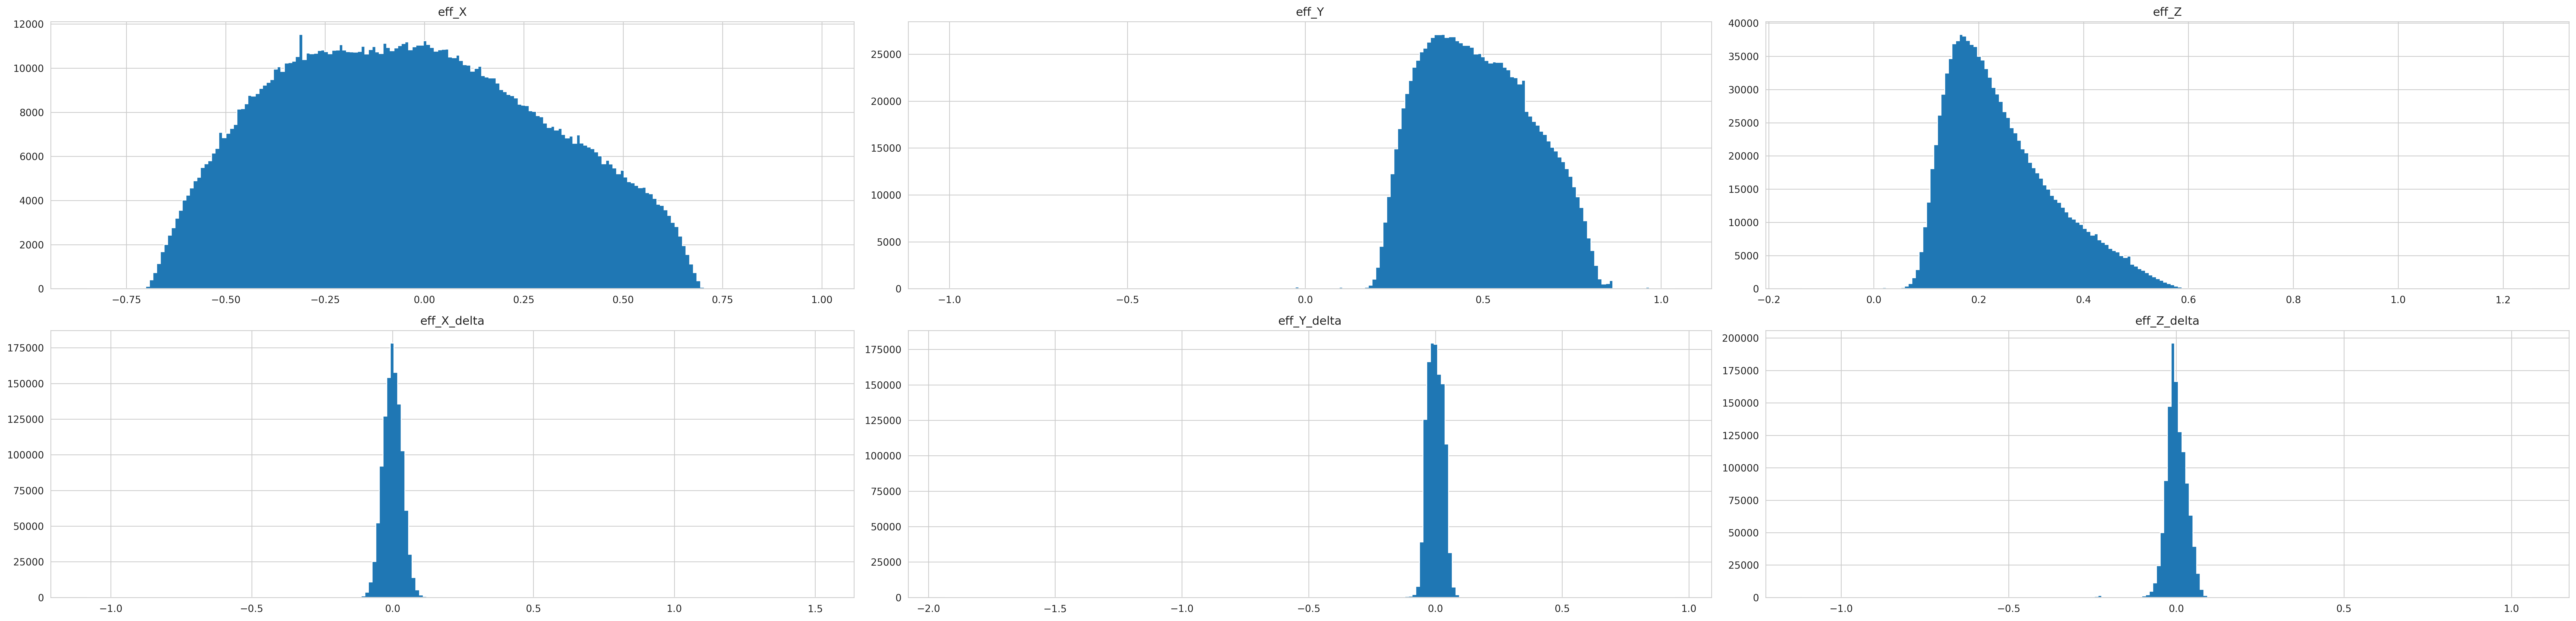

In [26]:
import matplotlib.pyplot as plt

# row = ['joint_0', 'joint_1', 'joint_2', 'joint_3', 'joint_4', 'joint_5', 'joint_6', 'magnet']
# row = ['joint_0_delta', 'joint_1_delta', 'joint_2_delta', 'joint_3_delta', 'joint_4_delta', 'joint_5_delta', 'joint_6_delta', 'magnet_delta']
rows = [['eff_X', 'eff_Y', 'eff_Z'], ['eff_X_delta', 'eff_Y_delta', 'eff_Z_delta']]
# rows = [['obj_X', 'obj_Y', 'obj_Z'], ['obj_X_delta', 'obj_Y_delta', 'obj_Z_delta']]
# row = ['color_R', 'color_G', 'color_B']

fig, ax = plt.subplots(2, 3, layout='tight', figsize=(37, 9), dpi=300)

for i, row in enumerate(rows):
    for j, col_name in enumerate(row):
        ax[i, j].hist(col_dict[col_name], bins=200, histtype='stepfilled')
        ax[i, j].set_title(col_name)

plt.savefig('plots/kuka/magnetic/kuka_magnetic_eff_hist.png')
# plt.show()

In [28]:
import h5py

with h5py.File('./data/magnetic/kuka_dir-rnd_1500k_n10_v2_f10.h5', 'w') as hf:
    hf.create_dataset('kuka_magnetic_fwd', data=np.hstack((X_fwd, y_fwd)))
    hf.create_dataset('kuka_magnetic_inv', data=np.hstack((X_inv, y_inv)))

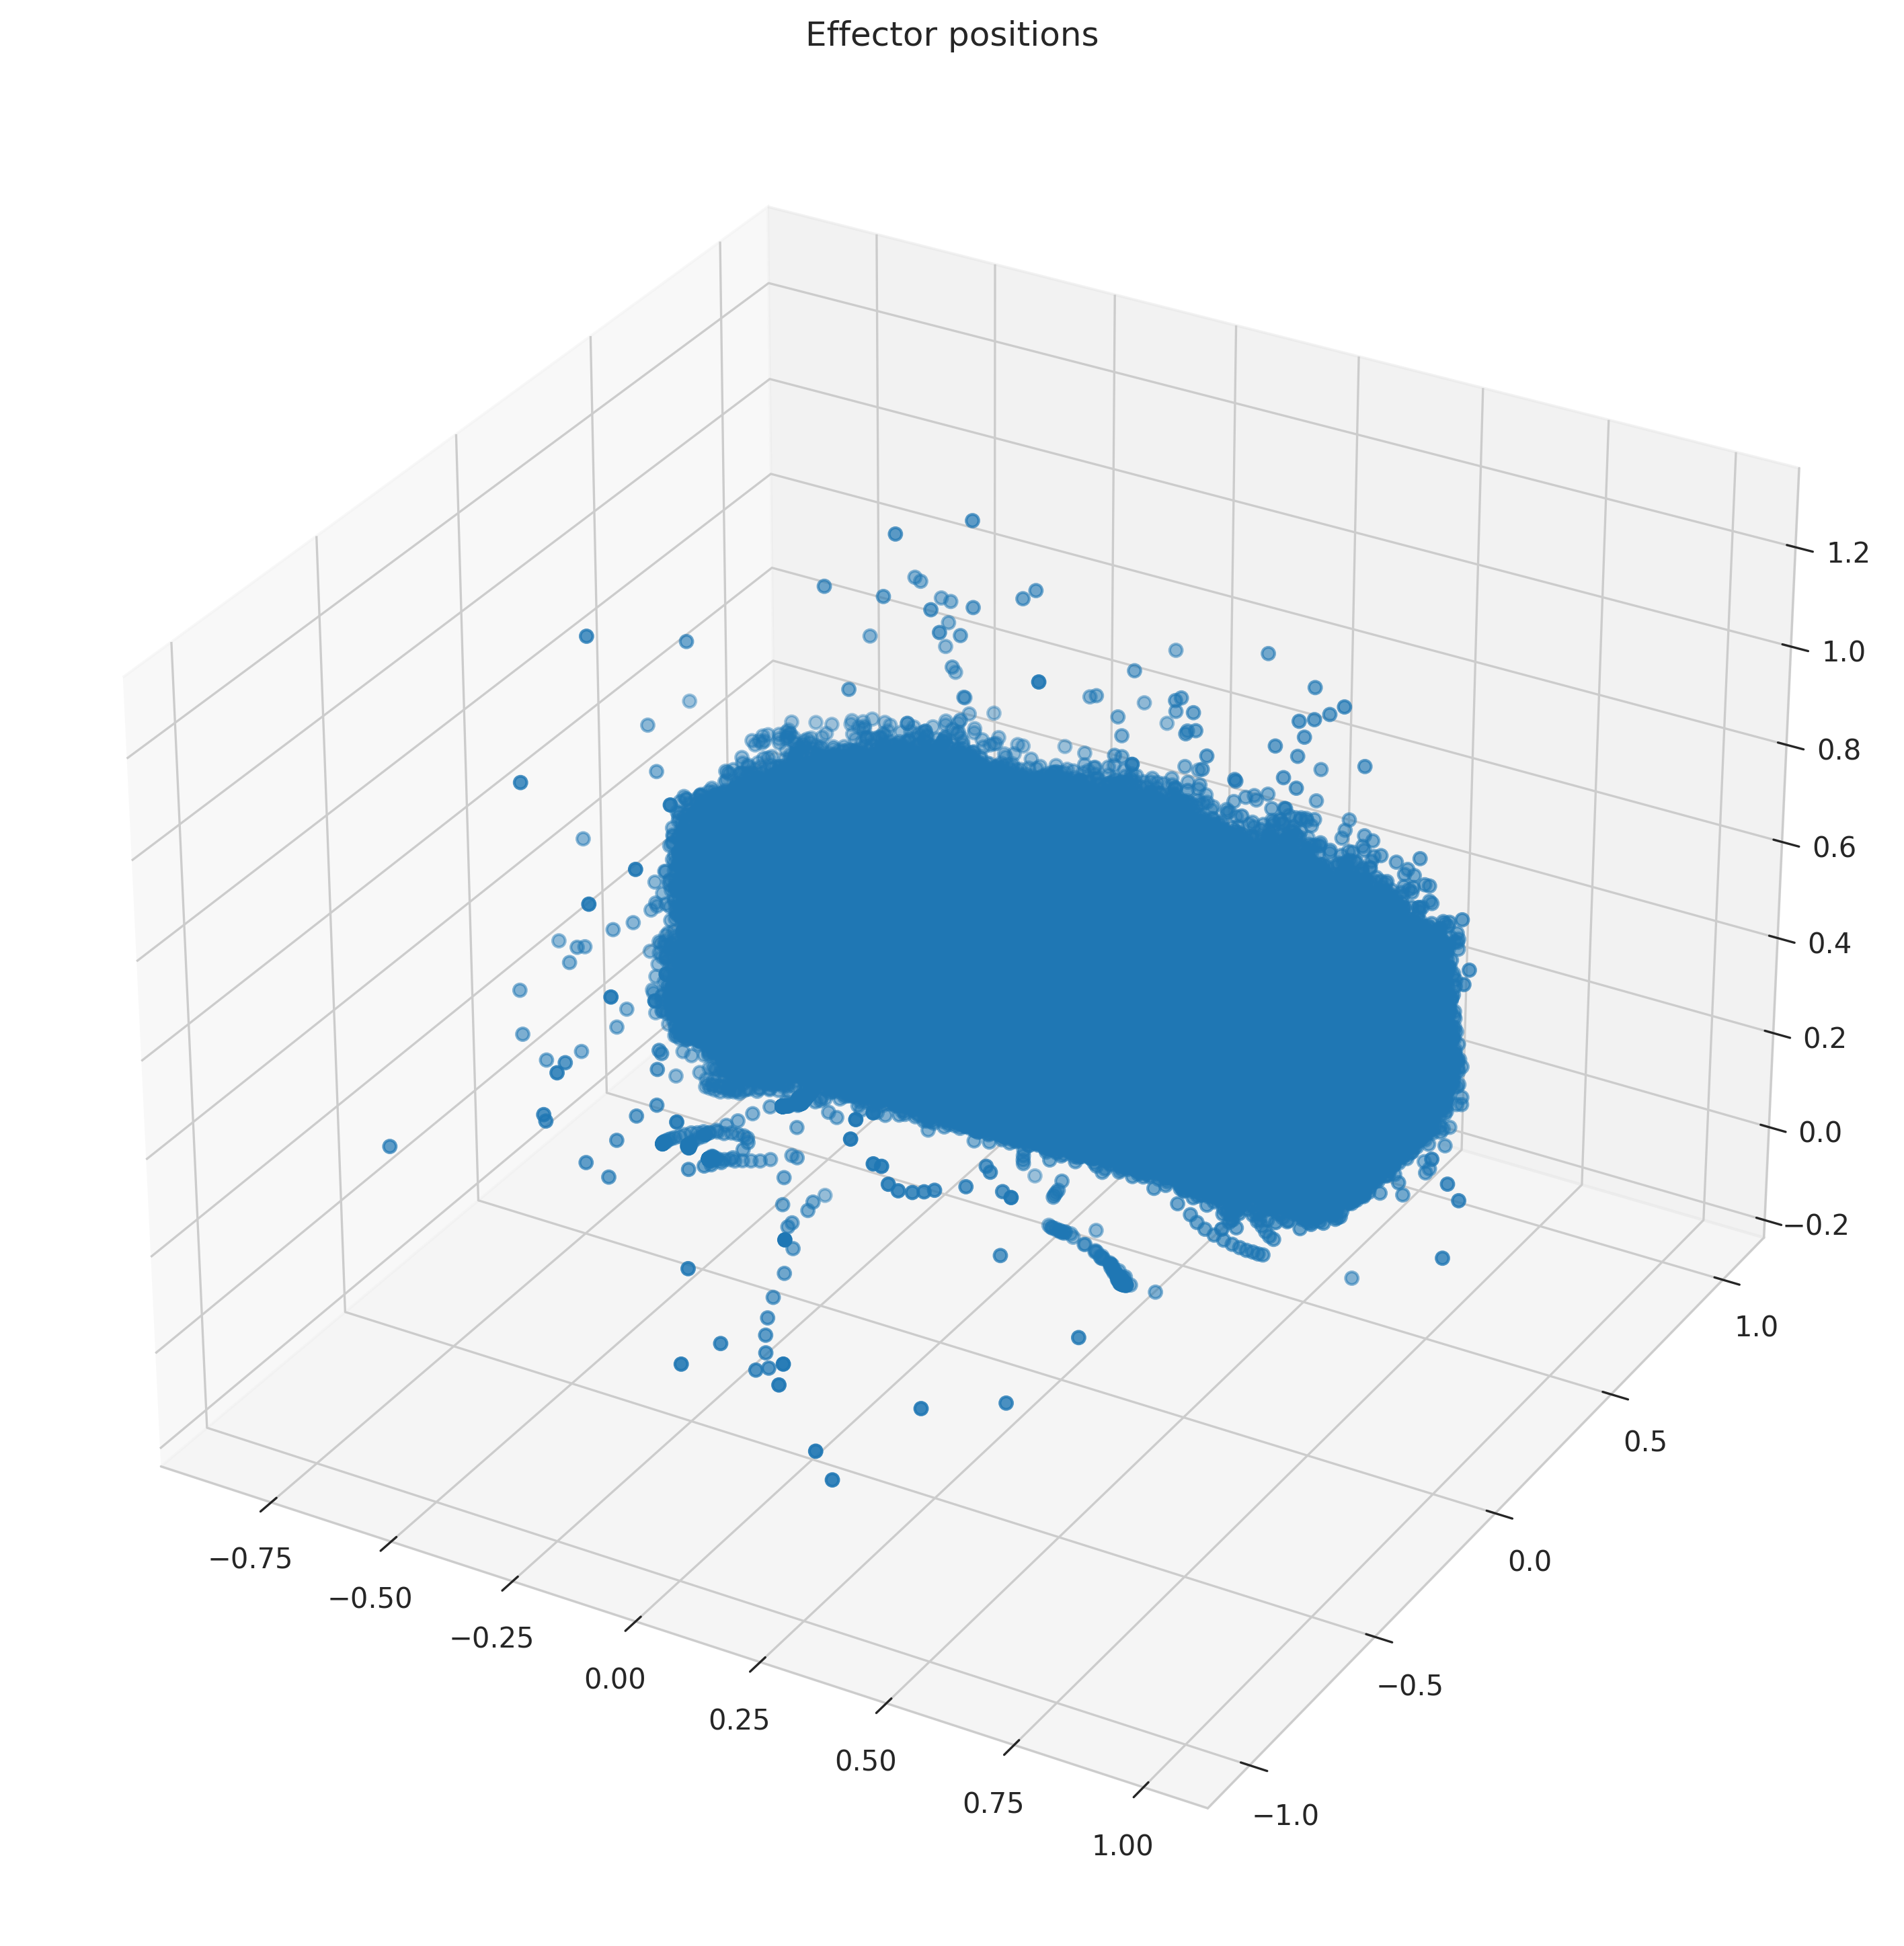

In [30]:
import matplotlib.pyplot as plt

fig = plt.figure(figsize=(12, 12), dpi=300)
ax = fig.add_subplot(projection='3d')

ax.scatter(
    col_dict['eff_X'],
    col_dict['eff_Y'],
    col_dict['eff_Z']
)
ax.set_title('Effector positions')

# plt.show()
plt.savefig('plots/kuka/magnetic/kuka_magnetic_eff_pos.png')

idx = 972244


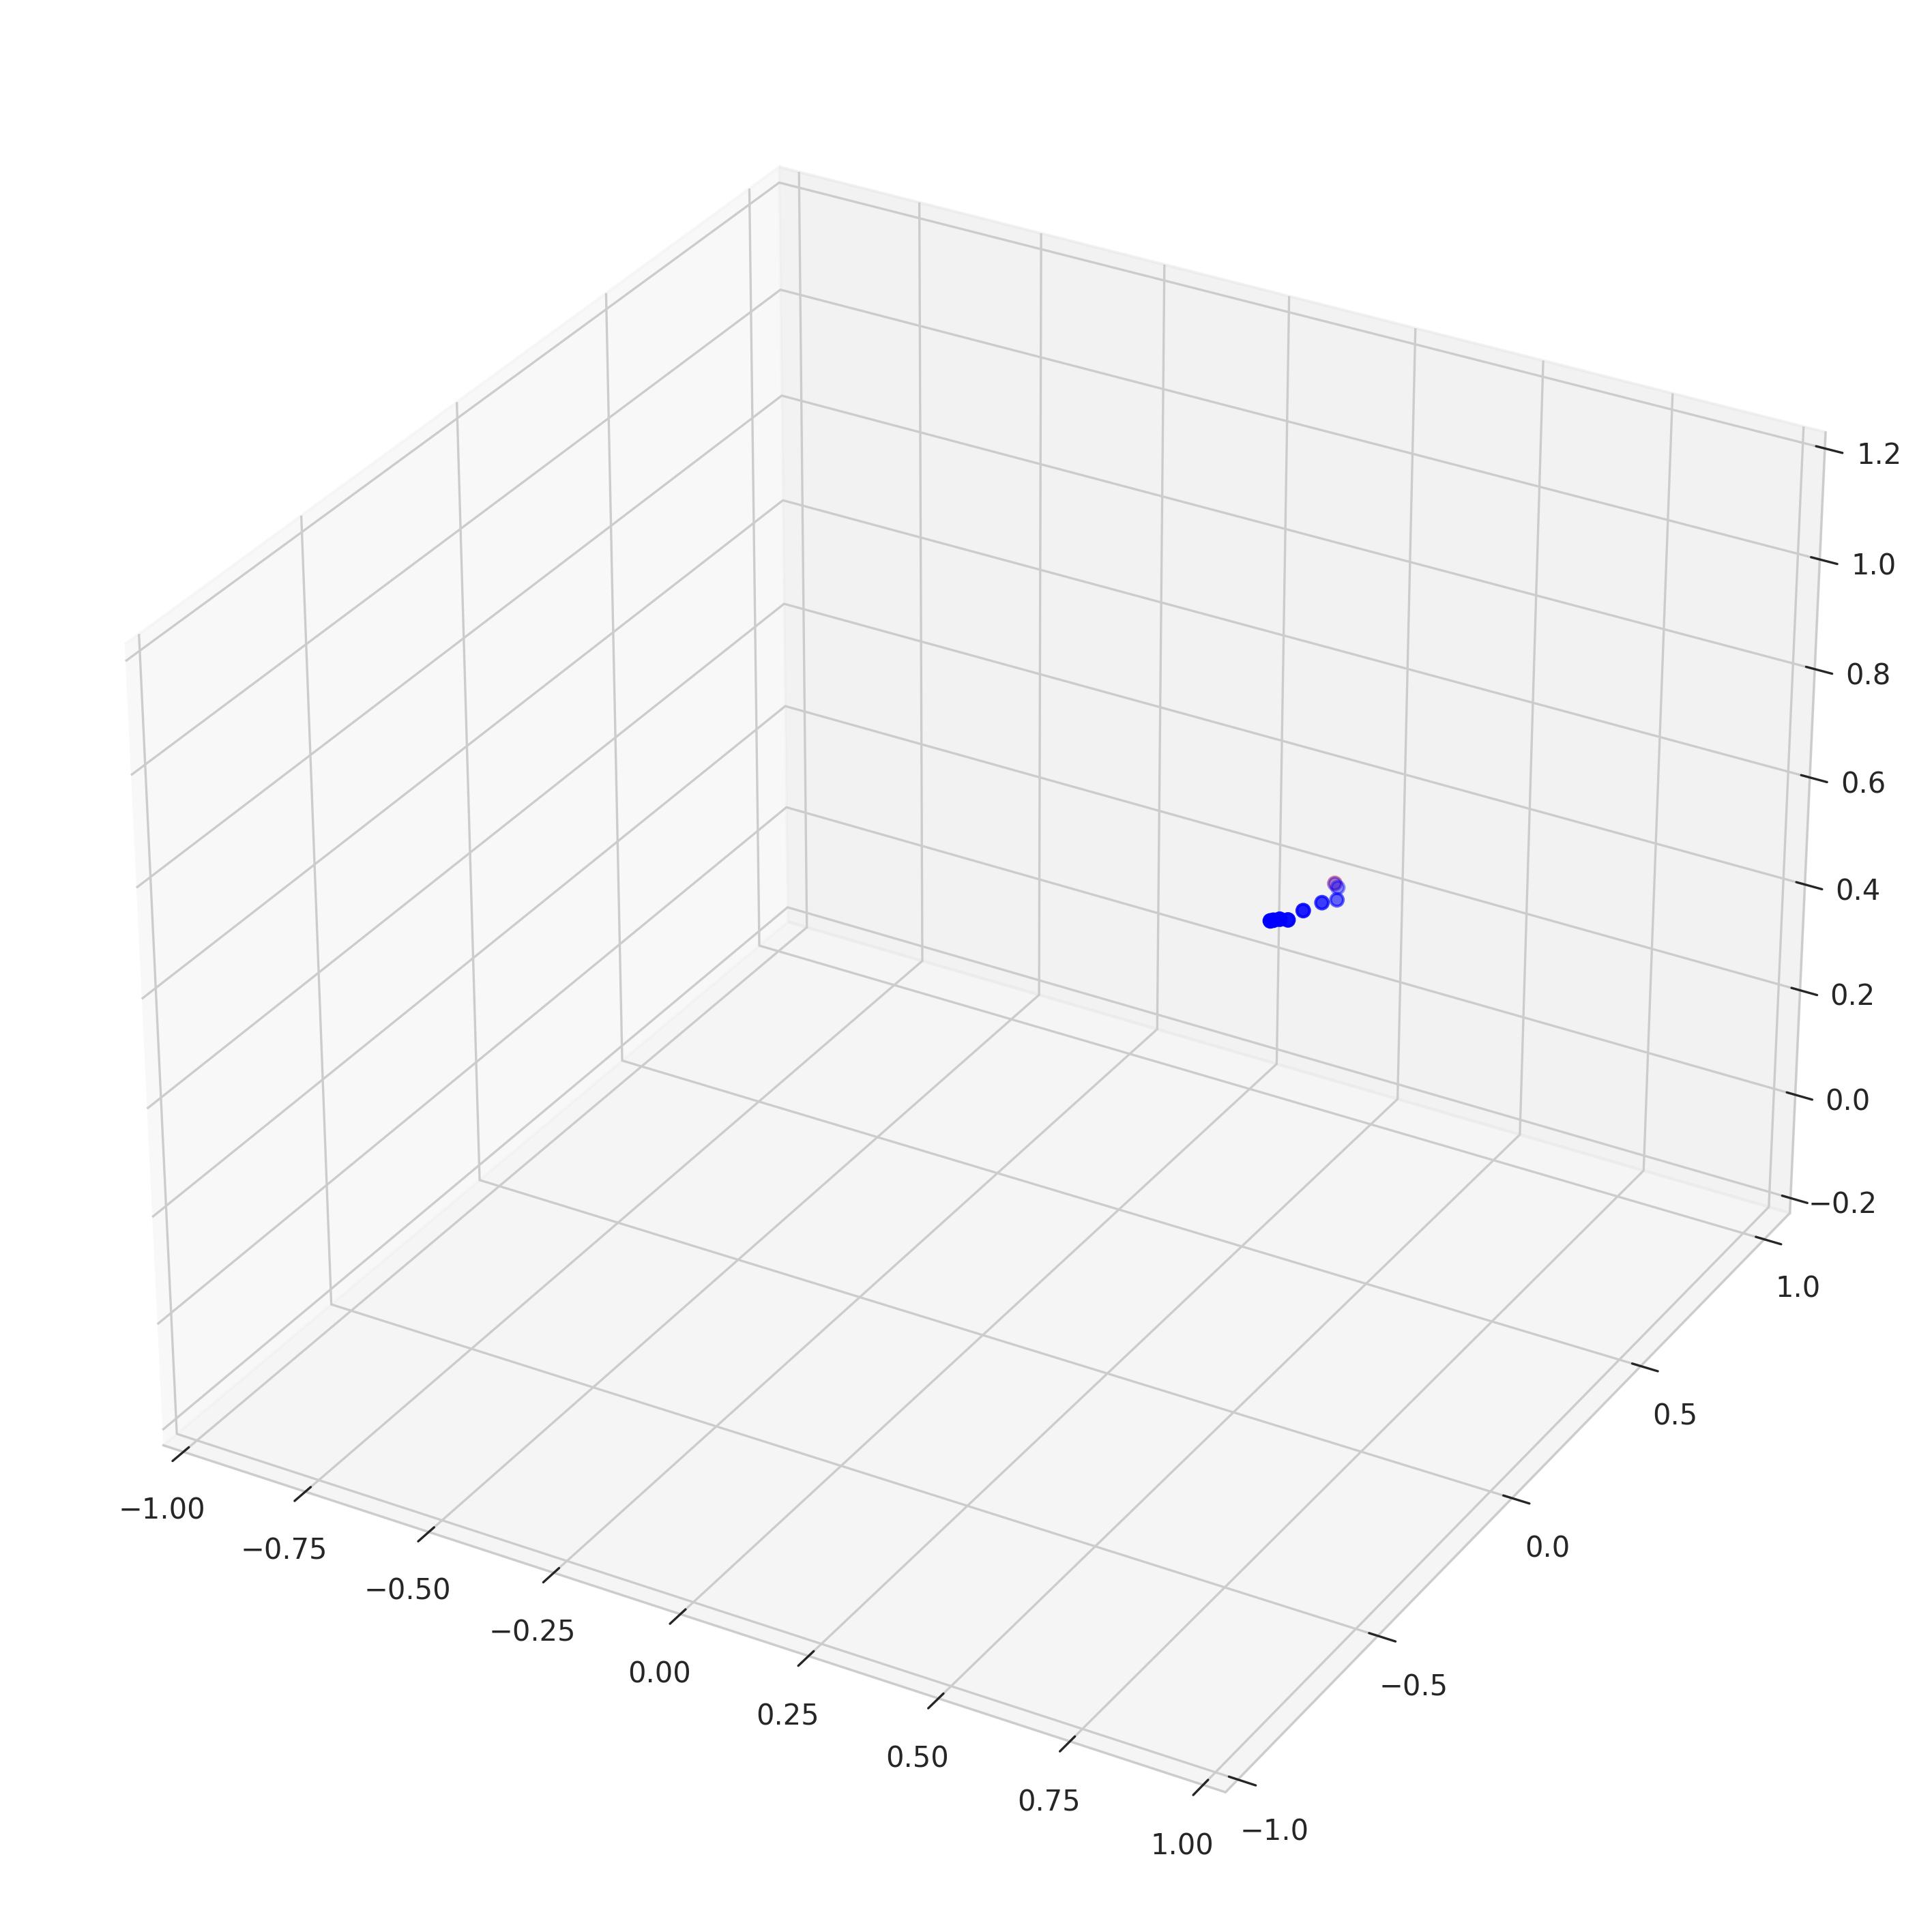

In [14]:
import random
import matplotlib.pyplot as plt

fig = plt.figure(figsize=(12, 12), dpi=300)
ax = fig.add_subplot(projection='3d')

idx = random.randrange(0, len(fwd_data))
print(f'idx = {idx}')

x = [col_dict['eff_X'][idx]] + col_dict['obj_X'][idx + 1:idx + 11]
y = [col_dict['eff_Y'][idx]] + col_dict['obj_Y'][idx + 1:idx + 11]
z = [col_dict['eff_Z'][idx]] + col_dict['obj_Z'][idx + 1:idx + 11]

c = ['red'] + ['blue' for _ in x[1:]]

ax.scatter(x, y, z, color=c)

ax.set_xticks(np.arange(-1, 1.25, 0.25))
ax.set_yticks(np.arange(-1, 1.5, 0.5))
ax.set_zticks(np.arange(-0.2, 1.4, 0.2))

plt.show()